In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import xarray as xr
import hvplot.xarray
import geoviews as gv
import geoviews.feature as gf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

import xopr.opr_access as xopr

In [60]:
# Establish an OPR session
# The purpose of this right now is just to define a local cache directory, but 
# in the future we might use it to determine which STAC catalog to use or something.
opr = xopr.OPRConnection(cache_dir="radar_cache")

In [61]:
# Use xopr to query the STAC catalog for radar frames within a bounding box

# TODO: Placeholder. No STAC catalog yet.

In [62]:
# Placeholder for loading data

#urls = [f"https://data.cresis.ku.edu/data/rds/2022_Antarctica_BaslerMKB/CSARP_standard/20221210_01/Data_20221210_01_{i:03d}.mat" for i in range(1, 10)]
urls = [f'https://data.cresis.ku.edu/data/rds/2016_Antarctica_DC8/CSARP_standard/20161026_05/Data_20161026_05_{i:03d}.mat' for i in range(1, 10)]

frames = [opr.load_frame(url) for url in urls]

In [63]:
# Inspect an individual frame
frames[0]

<xarray.Dataset> Size: 54MB
Dimensions:    (slow_time: 3337, twtt: 4024)
Coordinates:
  * slow_time  (slow_time) datetime64[ns] 27kB 2016-10-26T20:00:33.582408428 ...
  * twtt       (twtt) float64 32kB 3.737e-05 3.739e-05 ... 0.0001186 0.0001186
Data variables:
    Bottom     (slow_time) float64 27kB ...
    Data       (slow_time, twtt) float32 54MB ...
    Elevation  (slow_time) float64 27kB ...
    Heading    (slow_time) float64 27kB ...
    Latitude   (slow_time) float64 27kB -89.21 -89.21 -89.21 ... -88.76 -88.76
    Longitude  (slow_time) float64 27kB -67.92 -67.92 -67.92 ... -69.27 -69.27
    Pitch      (slow_time) float64 27kB ...
    Roll       (slow_time) float64 27kB ...
    Surface    (slow_time) float64 27kB ...
Attributes: (12/15)
    Conventions:          CF-1.8
    title:                Radar Echogram Data
    institution:          Open Polar Radar (OPR)
    source:               Airborne/ground-based radar sounder
    history:              Converted to CF-compliant format on 2025-07-30T20:5...
    references:           https://gitlab.com/openpolarradar/opr
    ...                   ...
    geospatial_lon_min:   -69.27209748979156
    geospatial_lon_max:   -67.916616976768
    time_coverage_start:  2016-10-26T20:00:33.582408428
    time_coverage_end:    2016-10-26T20:04:11.257261038
    season:               2016_Antarctica_DC8
    segment:              20161026_05

In [64]:
# Combine the frames into a single xarray Dataset representing the flight line
flight_line = xr.concat(frames, dim='slow_time', combine_attrs='drop_conflicts')
flight_line

<xarray.Dataset> Size: 486MB
Dimensions:    (slow_time: 30033, twtt: 4024)
Coordinates:
  * slow_time  (slow_time) datetime64[ns] 240kB 2016-10-26T20:00:33.582408428...
  * twtt       (twtt) float64 32kB 3.737e-05 3.739e-05 ... 0.0001186 0.0001186
Data variables:
    Bottom     (slow_time) float64 240kB nan nan nan nan nan ... nan nan nan nan
    Data       (slow_time, twtt) float32 483MB 7.877e-19 1.336e-18 ... 9.077e-23
    Elevation  (slow_time) float64 240kB 9.274e+03 9.274e+03 ... 9.315e+03
    Heading    (slow_time) float64 240kB -0.003312 -0.003397 ... -0.03449
    Latitude   (slow_time) float64 240kB -89.21 -89.21 -89.21 ... -85.18 -85.18
    Longitude  (slow_time) float64 240kB -67.92 -67.92 -67.92 ... -70.0 -70.0
    Pitch      (slow_time) float64 240kB 0.01966 0.01972 ... 0.0207 0.02071
    Roll       (slow_time) float64 240kB -0.07371 -0.07379 ... -0.02205 -0.02213
    Surface    (slow_time) float64 240kB 4.36e-05 4.36e-05 ... 5.307e-05
Attributes:
    Conventions:  CF-1.8
    title:        Radar Echogram Data
    institution:  Open Polar Radar (OPR)
    source:       Airborne/ground-based radar sounder
    references:   https://gitlab.com/openpolarradar/opr
    comment:      Polar radar echogram data with CF-compliant metadata
    season:       2016_Antarctica_DC8
    segment:      20161026_05

In [65]:
layers = None
try:
    layers = xopr.get_layers(flight_line)
    layers[1] # Display the surface layer as an example
except Exception as e:
    print(f"Error fetching layers: {e}")

In [66]:
# Plot a map of where the data was collected with a basemap on an EPSG:3031 projection
proj = ccrs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
coords = flight_line[['Longitude', 'Latitude']].to_dataframe().dropna()
(gf.ocean * gf.coastline * gv.Path([coords.values])).opts(projection=proj, aspect='equal')


:Overlay
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Path.I      :Path   [Longitude,Latitude]

In [67]:
#stacked = flight_line.Data.rolling(slow_time=10, center=True).mean()
stacked = flight_line.Data.resample(slow_time='1s').mean()
pwr_dB = 10*np.log10(np.abs(stacked))

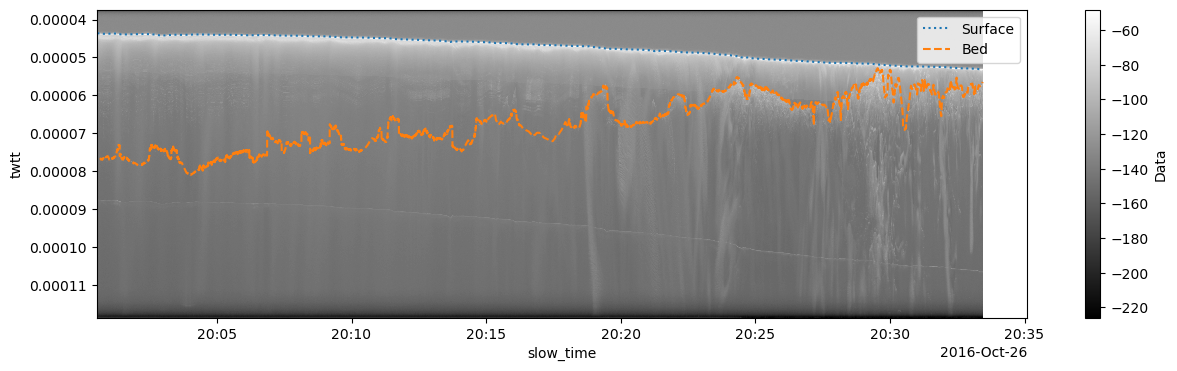

In [68]:
# slow_time_regular = pd.date_range(
# start=pwr_dB.slow_time.min().values,
# end=pwr_dB.slow_time.max().values,
# freq=pd.Timedelta(seconds=0.01)
# )
# pwr_dB_interp = pwr_dB.interp(slow_time=slow_time_regular)

fig, ax = plt.subplots(figsize=(15, 4))
pwr_dB.plot.imshow(x='slow_time', cmap='gray', ax=ax)
ax.invert_yaxis()

if layers:
    layers[1]['twtt'].plot(ax=ax, x='slow_time', linestyle=':', label='Surface')
    layers[2]['twtt'].plot(ax=ax, x='slow_time', linestyle='--', label='Bed')
    ax.legend()

In [69]:
print(xopr.generate_citation(flight_line))

== Data Citation ==
No specific citation information was retrieved for this dataset. By default, please cite:
CReSIS. 2024. REPLACE_WITH_RADAR_NAME Data, Lawrence, Kansas, USA. Digital Media. http://data.cresis.ku.edu/.
== Processing Citation ==
Data was processed using the Open Polar Radar (OPR) Toolbox: https://doi.org/10.5281/zenodo.5683959
Please cite the OPR Toolbox as:
Open Polar Radar. (2024). opr (Version 3.0.1) [Computer software]. https://gitlab.com/openpolarradar/opr/. https://doi.org/10.5281/zenodo.5683959
And include the following acknowledgment:
We acknowledge the use of software from Open Polar Radar generated with support from the University of Kansas, NASA grants 80NSSC20K1242 and 80NSSC21K0753, and NSF grants OPP-2027615, OPP-2019719, OPP-1739003, IIS-1838230, RISE-2126503, RISE-2127606, and RISE-2126468.

